## The Tools

In [2]:
#navigation
import os

#data wrangling
import pandas as pd
import numpy as np

#model building
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from sklearn.feature_selection import RFE

#model scoring
from sklearn.metrics import r2_score

#data visualization
import matplotlib.pyplot as plt
import pylab 

## Helper Functions

In [208]:
def diagnose_features(top10_features_df,model,X_train,X_test,y_train,y_test,score_cutoff=0,combine=False,combine_number=2):
    features_to_use = list(top10_features_df['feature name'].values)
    
    #empty lists for dataframe formation
    score_value = []
    score_name = []
    
    if combine:
        features_to_use = combinations(features_to_use,combine_number)
    
    for feature in features_to_use:
        
        feature=list(feature)
        
        test_fet = X_test[feature]
        train_fet = X_train[feature]
        
        
        if not combine:
            test_fet = test_fet.values.reshape(-1,1)
            train_fet = train_fet.values.reshape(-1,1)
            
        #print("LEN OF FEATURE",len(feature))
        
        #print("\n\t\tUSING %s AS FEATURE\n"%feature)
        #fit model
        model = model
        model.fit(train_fet,y_train)
        predicted = model.predict(test_fet)
        score = model.score(test_fet,y_test)
        
        #data adding
        score_value.append(score) #add score to list
        score_name.append((feature)) #add name of feature combination to list

        #plot it if the score is greater than cutoff
        if score>=score_cutoff and plot==True:
            fig = plt.figure(figsize=(9,7))
            plt.scatter(predicted,y_test,label="S_PC Values")
            plt.scatter(predicted,predicted,label='Linear Fit (R2 score: %0.2f)'%score)
            plt.xlabel("Predicted values")
            plt.ylabel("True values")
            plt.title("Linear Regression: %s vs. Scnf"%feature)
            plt.legend()
            plt.show()
            
    df = pd.DataFrame([score_value,score_name],['R2 score value','score name']).transpose()
    df['n combinations'] = df['score name'].apply(len)
    return df
            

In [209]:
def get_top10(fitted_model,features):
    results = None
    try:
        results = pd.DataFrame(sorted(list(zip(fitted_model.coef_[0],features)),reverse=True),columns=['coefficient','feature name'])
    except:
        results = pd.DataFrame(sorted(list(zip(fitted_model.coef_,features)),reverse=True),columns=['coefficient','feature name'])

    top10 = results.iloc[:10]
    return top10

In [210]:
def lasso_fit_pred(alpha_val_list, sort_by_abs_value=False,print_names=True,print_coefs=True):
    results = []
    top_10_coef = []
    for alpha in alpha_val_list:
        print("Running regression with Alpha = %s \n"%alpha)
        #Lasso regressor
        model_lasso = Lasso(alpha,normalize=False)

        #Fit model
        model_lasso.fit(X_train_scaled,y_train_scaled)

        #Make predictions and score them
        y_pred_lasso = model_lasso.predict(X_test_scaled)
        score_val = model_lasso.score(X_test_scaled,y_test_scaled)
        
        #sort results
        top_10 = sorted(zip(model_lasso.coef_,X_train_scaled.columns),reverse=True)[:10]
        if sort_by_abs_value:
            #split up the tuple into two lists
            coefs = []
            names = []
            for i in top_10:
                coefs.append(i[0])
                names.append(i[1])
            #turn coefficients into absolute values
            coefs = list(map(abs,coefs))
            
            #zip them and sort them into a tuple
            top_10 = sorted(zip(coefs,names),reverse=True)
        
        #store result in tuple:
        results.append((alpha,score_val))
        top_10_coef.append(top_10)
        
    
    #print out names of most important features
    if print_names:
        print("Results in shape: ('alpha value','score'):")
        print(results,"\n")

        top_10_names = []
        for i in top_10_coef:
            prelim_list = []
            for j in i:
                prelim_list.append(j[1])
            top_10_names.append(prelim_list)

        print("\nTop 10 Features in each:")
        for i in top_10_names:
            print(i)

    #print a dataframe with top 10 coefficients
    if print_coefs:
        for i in top_10_coef:
            print(pd.DataFrame(i))
    return results, top_10_coef

In [211]:
def scatter_plot(predicted, true, title,score,xaxis="Predicted Values",yaxis="True Values",savefig=False,filename=None):
    fig = plt.figure(figsize=(9,7))
    plt.scatter(predicted,true,label="S_PC Values")
    plt.scatter(predicted,predicted,label='Linear Fit (R2 score: %0.2f)'%score)
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.title(title)
    plt.legend()
    plt.show()
    
    if savefig:
        fig.savefig("./figures/"+filename+".svg",bbox_inches='tight')

In [212]:
def tptn(true_data,pred_data,target_val):
    output = pd.DataFrame(data={'true values':true_data[target_val],'predicted values':pred_data[target_val]})
    
    true = output[output['predicted values']==output['true values']]
    false = output[output['predicted values']!=output['true values']]

    tp = true[true['predicted values']==1]
    tn = true[true['predicted values']==0]

    fp = false[false['predicted values']==1]
    fn = false[false['predicted values']==0]
    
    print('Number of TP: %s\nNumber of TN: %s\nNumber of FP: %s\nNumber of FN: %s\n' %(len(tp),len(tn),len(fp),len(fn)))
    
    return tp,tn,fp,fn

## The Data

In [213]:
#aggregated sd2e data
df_aggregated_sd2e = pd.read_csv('/home/jupyter/tacc-work/test-harness-v3/versioned-datasets/data/protein-design/aggregated_data/all_libs_cleaned.v1.aggregated_data.csv',comment="#" )

#total S_PC and TbD features
df_fet = pd.read_csv("/home/jupyter/tacc-work/test-harness/protein-design/protstab_test_harness_and_leaderboard/model_runner_data/default_model_runner_data/spc_tbd_features.csv",comment="#").dropna(axis=0)

# *** standardize data locally ****
# scaler = StandardScaler()
# fet_to_standardize = df_fet.iloc[:,2:].columns
# df_fet[fet_to_standardize] = scaler.fit_transform(df_fet[fet_to_standardize])


#train test splits by Hamed
test_index = pd.read_csv("/home/jupyter/tacc-work/test-harness-v3/versioned-datasets/data/protein-design/index/test_harness.test.v2.index.csv",comment="#")
train_index = pd.read_csv("/home/jupyter/tacc-work/test-harness-v3/versioned-datasets/data/protein-design/index/test_harness.train.v2.index.csv",comment="#")

#split dataframes (S_PC and TbD)
df_fet_train = df_fet.merge(train_index)
df_fet_test = df_fet.merge(test_index)

#split dataframes (aggregated)
df_aggregated_train = df_aggregated_sd2e.merge(df_fet_train).drop(['assay_library','chip_name','library'],axis=1)
df_aggregated_test = df_aggregated_sd2e.merge(df_fet_test).drop(['assay_library','chip_name','library'],axis=1)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (142) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,dataset,name,sequence,dssp,topology,description,stabilityscore,stabilityscore_calibrated,stabilityscore_t,stabilityscore_calibrated_t,...,ss_contributes_core,ss_sc,sum_best_frags,total_score,tryp_cut_sites,two_core_each,worst6frags,worstfrag,assay_library,chip_name
65113,Rocklin,HEEH_rd2_0365,PQEAEDRARKIKKKNLTTVTIGNYELRYTNPEELARAAKKLLI,LHHHHHHHHHHHHLLLLEEEELLEEEELLLHHHHHHHHHHHHL,HEEH,data/Rocklin_2017_Science/HEEH_rd2_0365,-0.080,-0.080,-0.080,-0.080,...,1.000,0.773,10.027,-102.092,10,0.500,3.607,0.831,2.0,NaN
65114,Rocklin,EEHEE_rd2_0259,TTLEVNGEKYTFTSTTEAQEFAKKFGATTIEVRGTTVRVTR,LEEEELLEEEELLLHHHHHHHHHHHLLLEEEEELLEEEEEL,EEHEE,data/Rocklin_2017_Science/EEHEE_rd2_0259,-0.050,-0.050,-0.050,-0.050,...,1.000,0.744,9.606,-86.716,6,0.400,3.131,0.647,2.0,NaN
65115,Rocklin,EEHEE_rd1_0176,PRVRSNGQTYQATSREEARKIAKKANGKTVEETNDEFRVKK,LEEEELLEEEELLLHHHHHHHHHHHLLLEEEEELLEEEEEL,EEHEE,data/Rocklin_2017_Science/EEHEE_rd1_0176,0.540,0.540,0.540,0.540,...,1.000,0.738,17.309,-81.592,11,0.200,6.404,1.389,1.0,NaN
65116,Rocklin,EEHEE_rd1_1091,SKIRVNGQDIDVDSEEKAQKEAKKAGANREKKHGNTYRFEG,LEEEELLEEEELLLHHHHHHHHHHHLLLEEEEELLEEEEEL,EEHEE,data/Rocklin_2017_Science/EEHEE_rd1_1091,0.040,0.040,0.040,0.040,...,0.600,0.675,16.087,-91.977,10,0.200,6.237,1.404,1.0,NaN
65117,Rocklin,HEEH_rd2_1282,RVEEDQERIERAVKKGGTFEFNGLKVDSDEAAERAKEVAKRLK,LHHHHHHHHHHHHHHLLLEEELLEEELLHHHHHHHHHHHHHHL,HEEH,data/Rocklin_2017_Science/HEEH_rd2_1282,0.060,0.060,0.110,0.110,...,1.000,0.669,9.307,-98.831,11,0.500,3.822,1.159,2.0,NaN
65118,Rocklin,EHEE_rd1_0150,TRRETYTNEDEVDEVRKQLESKGGEVRVREKNGEFTLEHD,LEEEEELLHHHHHHHHHHHHLLLLLEEEEEELLEEEEEEL,EHEE,data/Rocklin_2017_Science/EHEE_rd1_0150,-0.180,-0.180,0.040,0.040,...,1.000,0.700,10.754,-78.591,8,0.750,3.916,0.767,1.0,NaN
65119,Rocklin,EEHEE_rd3_0713,TTVQVGNYTYTADTPEAAKKLAKKLAKIFNATVEVHGDTIKLH,LEEEELLEEEELLLHHHHHHHHHHHHHHHLLLEEEELLEEEEL,EEHEE,data/Rocklin_2017_Science/EEHEE_rd3_0713,1.190,1.190,1.835,1.835,...,1.000,0.780,11.884,-94.393,6,0.600,3.778,0.807,3.5,NaN
65120,Rocklin,HHH_rd1_0039,PKDELQKRIEEARERGDRDEIERLLRKIGYSDDEASKIAKKLG,LHHHHHHHHHHHHHHLLHHHHHHHHHHHLLLHHHHHHHHHHHL,HHH,data/Rocklin_2017_Science/HHH_rd1_0039,1.095,1.095,1.745,1.745,...,1.000,0.758,6.045,-119.083,12,0.333,1.916,0.397,2.5,NaN
65121,Rocklin,HEEH_rd3_0188,PDELKKLVKKLAKLGKPINVNGITFNPNNPEAVQAALEAAKKV,LLHHHHHHHHHHHHLLLEEELLEEELLLLHHHHHHHHHHHHHL,HEEH,data/Rocklin_2017_Science/HEEH_rd3_0188,0.780,0.780,0.780,0.780,...,1.000,0.799,11.198,-118.242,7,0.500,4.314,1.252,3.0,NaN
65122,Rocklin,EEHEE_rd4_0742,KTVHINGNEYHFDNPEEVKKFVETVVKQLGVQLERHGDTWKVS,LEEEELLEEEELLLHHHHHHHHHHHHHHHLLLEEEELLEEEEL,EEHEE,data/Rocklin_2017_Science/EEHEE_rd4_0742,0.460,0.460,0.730,0.730,...,1.000,0.726,11.158,-124.756,6,0.200,3.500,0.683,4.0,NaN


## The Models

### Splits

In [9]:
#features subdivided
features_string = list(df_aggregated_train.columns[0:6])
features_entropy = list(df_aggregated_train.columns[141:161])
features_tbd = list(df_aggregated_train.columns[161:386])
features_scores = list(df_aggregated_train.columns[6:28])
features_rosetta = list(df_aggregated_train.columns[28:141])

In [10]:
#set up splits
X_train = df_aggregated_train.drop(features_string+features_entropy+features_tbd+features_scores,axis=1)
y_train = df_aggregated_train['S_PC']

X_test = df_aggregated_test.drop(features_string+features_entropy+features_tbd+features_scores,axis=1)
y_test = df_aggregated_test['S_PC']

#merged X and y data
X = pd.concat([X_train,X_test])
y = pd.concat([y_train,y_test])


In [11]:
#normalize data
scaler = StandardScaler()

#fix the X values
scaler.fit(X)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X.columns)
X_scaled = pd.DataFrame(scaler.transform(X),columns=X.columns)

#fix the y values
scaler.fit(y.values.reshape(-1,1))
y_train_scaled = scaler.transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1,1))
y_scaled = scaler.transform(y.values.reshape(-1,1))

In [370]:
#save dataframes to folder
df_list = ([df_fet,df_aggregated_sd2e,df_aggregated_test,df_aggregated_train,X_train_scaled,X_test_scaled,y_train_scaled,y_test_scaled,X_scaled,y_scaled],
           ["df_fet","df_aggregated_sd2e","df_aggregated_test","df_aggregated_train","X_train_scaled","X_test_scaled","y_train_scaled","y_test_scaled","X_scaled","y_scaled"])
for i in range(len(df_list[0])):
    name = df_list[1][i]
    df = df_list[0][i]
    try:
        df.to_csv('./dataframes/%s.csv'%name)
    except AttributeError:
        np.savetxt("./dataframes/"+name+".csv",df,delimiter=',')

### Linear Regression

In [1]:
#set up a linear regression trained to predict S_PC
model_lnr = LinearRegression(normalize=False)

#fit the data
model_lnr.fit(X_train_scaled,y_train_scaled)

#predict
y_pred_lnr = model_lnr.predict(X_test_scaled)

#get results
print("R2 Score: ",model_lnr.score(X_test_scaled,y_test_scaled))

NameError: name 'LinearRegression' is not defined

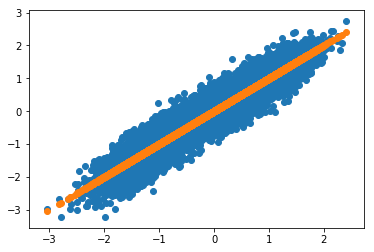

In [13]:
y_pred = model_lnr.predict(X_test_scaled)
plt.scatter(y_pred,y_test_scaled)
plt.scatter(y_pred,y_pred)
plt.show()

No handles with labels found to put in legend.


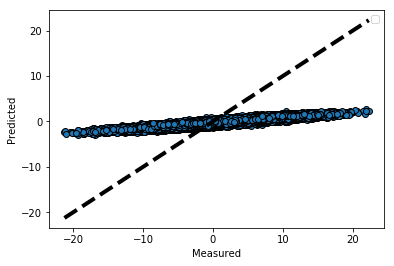

In [14]:
#above seems too good to be true. let's cross validate

#code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_predict.html#sphx-glr-auto-examples-model-selection-plot-cv-predict-py
predicted = cross_val_predict(model_lnr, X_scaled,y_scaled, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.legend()
plt.show()

In [15]:
results = pd.DataFrame(sorted(list(zip(model_lnr.coef_[0],X.columns)),reverse=True))
results[results.iloc[:,0]>=1] 

,0,1
0,9.271055e+11,n_hydrophobic
1,4.109565e+11,Tend_absq
2,9.315590e+10,Tend_netq
3,6.535838e+10,T1_netq
4,3.857950e+10,contact_all
5,3.543570e+10,nres
6,2.783461e+10,entropy
7,2.028792e+10,dslf_fa13
8,7.654431e+09,n_res
9,8.259965e+02,buried_np


### Lasso Regression

In [16]:
boop = Lasso()
boop.fit(X_train_scaled,y_train_scaled)
pred_boop = boop.predict(X_test)
r2_score(y_test_scaled,pred_boop)

-7.09221189998388e-07

In [17]:
lasso_fit_pred([0,0.1,0.2,0.3])

Running regression with Alpha = 0 



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Running regression with Alpha = 0.1 

Running regression with Alpha = 0.2 

Running regression with Alpha = 0.3 

Results in shape: ('alpha value','score'):
[(0, 0.8988723152532534), (0.1, 0.7048001589618567), (0.2, 0.6427029590285926), (0.3, 0.5792539408040498)] 


Top 10 Features in each:
['total_score', 'fa_atr', 'hydrophobicity', 'tryp_cut_sites', 'exposed_hydrophobics', 'n_res', 'fa_atr_per_res', 'exposed_polars', 'bb', 'fa_intra_atr_xover4']
['hbond_sr_bb', 'holes', 'fa_atr_per_res', 'worstfrag', 'worst6frags', 'two_core_each', 'tryp_cut_sites', 'total_score', 'sum_best_frags', 'ss_sc']
['hbond_sr_bb', 'holes', 'fa_atr_per_res', 'worstfrag', 'worst6frags', 'two_core_each', 'tryp_cut_sites', 'total_score', 'sum_best_frags', 'ss_sc']
['hbond_sr_bb', 'worstfrag', 'worst6frags', 'two_core_each', 'tryp_cut_sites', 'total_score', 'sum_best_frags', 'ss_sc', 'ss_contributes_core', 'score_per_res']
          0                     1
0  1.241919           total_score
1  1.146048            

([(0, 0.8988723152532534),
  (0.1, 0.7048001589618567),
  (0.2, 0.6427029590285926),
  (0.3, 0.5792539408040498)],
 [[(1.2419190490444731, 'total_score'),
   (1.146048278572137, 'fa_atr'),
   (0.7366453327821862, 'hydrophobicity'),
   (0.5931113087061619, 'tryp_cut_sites'),
   (0.5602933144447082, 'exposed_hydrophobics'),
   (0.549959123313881, 'n_res'),
   (0.4307456062182323, 'fa_atr_per_res'),
   (0.32187396244607785, 'exposed_polars'),
   (0.30987996382680166, 'bb'),
   (0.287454908353542, 'fa_intra_atr_xover4')],
  [(0.21665752957475556, 'hbond_sr_bb'),
   (0.08176756756219547, 'holes'),
   (0.08121565117447556, 'fa_atr_per_res'),
   (-0.0, 'worstfrag'),
   (0.0, 'worst6frags'),
   (-0.0, 'two_core_each'),
   (0.0, 'tryp_cut_sites'),
   (0.0, 'total_score'),
   (0.0, 'sum_best_frags'),
   (-0.0, 'ss_sc')],
  [(0.08672303778849194, 'hbond_sr_bb'),
   (0.050324564053194284, 'holes'),
   (0.01875497158646118, 'fa_atr_per_res'),
   (-0.0, 'worstfrag'),
   (-0.0, 'worst6frags'),
   (-0

In [18]:
lasso_fit_pred(np.arange(1,step=.1),print_coefs=True)

Running regression with Alpha = 0.0 



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # Remove the CWD from sys.path while we load stuff.


Running regression with Alpha = 0.1 

Running regression with Alpha = 0.2 

Running regression with Alpha = 0.30000000000000004 

Running regression with Alpha = 0.4 

Running regression with Alpha = 0.5 

Running regression with Alpha = 0.6000000000000001 

Running regression with Alpha = 0.7000000000000001 

Running regression with Alpha = 0.8 

Running regression with Alpha = 0.9 

Results in shape: ('alpha value','score'):
[(0.0, 0.8988723152532534), (0.1, 0.7048001589618567), (0.2, 0.6427029590285926), (0.30000000000000004, 0.5792539408040498), (0.4, 0.5036459179117927), (0.5, 0.4065807669114145), (0.6000000000000001, 0.28797306838223824), (0.7000000000000001, 0.14782204844456226), (0.8, -7.09221189998388e-07), (0.9, -7.09221189998388e-07)] 


Top 10 Features in each:
['total_score', 'fa_atr', 'hydrophobicity', 'tryp_cut_sites', 'exposed_hydrophobics', 'n_res', 'fa_atr_per_res', 'exposed_polars', 'bb', 'fa_intra_atr_xover4']
['hbond_sr_bb', 'holes', 'fa_atr_per_res', 'worstfrag', 

([(0.0, 0.8988723152532534),
  (0.1, 0.7048001589618567),
  (0.2, 0.6427029590285926),
  (0.30000000000000004, 0.5792539408040498),
  (0.4, 0.5036459179117927),
  (0.5, 0.4065807669114145),
  (0.6000000000000001, 0.28797306838223824),
  (0.7000000000000001, 0.14782204844456226),
  (0.8, -7.09221189998388e-07),
  (0.9, -7.09221189998388e-07)],
 [[(1.2419190490444731, 'total_score'),
   (1.146048278572137, 'fa_atr'),
   (0.7366453327821862, 'hydrophobicity'),
   (0.5931113087061619, 'tryp_cut_sites'),
   (0.5602933144447082, 'exposed_hydrophobics'),
   (0.549959123313881, 'n_res'),
   (0.4307456062182323, 'fa_atr_per_res'),
   (0.32187396244607785, 'exposed_polars'),
   (0.30987996382680166, 'bb'),
   (0.287454908353542, 'fa_intra_atr_xover4')],
  [(0.21665752957475556, 'hbond_sr_bb'),
   (0.08176756756219547, 'holes'),
   (0.08121565117447556, 'fa_atr_per_res'),
   (-0.0, 'worstfrag'),
   (0.0, 'worst6frags'),
   (-0.0, 'two_core_each'),
   (0.0, 'tryp_cut_sites'),
   (0.0, 'total_score

In [19]:
lasso_fit_pred([1,10],print_names=False,print_coefs=True,sort_by_abs_value=False)

Running regression with Alpha = 1 

Running regression with Alpha = 10 

     0                    1
0 -0.0            worstfrag
1 -0.0          worst6frags
2 -0.0        two_core_each
3 -0.0       tryp_cut_sites
4  0.0          total_score
5 -0.0       sum_best_frags
6 -0.0                ss_sc
7 -0.0  ss_contributes_core
8  0.0        score_per_res
9 -0.0   res_count_core_SCN
     0                    1
0 -0.0            worstfrag
1 -0.0          worst6frags
2 -0.0        two_core_each
3 -0.0       tryp_cut_sites
4  0.0          total_score
5 -0.0       sum_best_frags
6 -0.0                ss_sc
7 -0.0  ss_contributes_core
8  0.0        score_per_res
9 -0.0   res_count_core_SCN


([(1, -7.09221189998388e-07), (10, -7.09221189998388e-07)],
 [[(-0.0, 'worstfrag'),
   (-0.0, 'worst6frags'),
   (-0.0, 'two_core_each'),
   (-0.0, 'tryp_cut_sites'),
   (0.0, 'total_score'),
   (-0.0, 'sum_best_frags'),
   (-0.0, 'ss_sc'),
   (-0.0, 'ss_contributes_core'),
   (0.0, 'score_per_res'),
   (-0.0, 'res_count_core_SCN')],
  [(-0.0, 'worstfrag'),
   (-0.0, 'worst6frags'),
   (-0.0, 'two_core_each'),
   (-0.0, 'tryp_cut_sites'),
   (0.0, 'total_score'),
   (-0.0, 'sum_best_frags'),
   (-0.0, 'ss_sc'),
   (-0.0, 'ss_contributes_core'),
   (0.0, 'score_per_res'),
   (-0.0, 'res_count_core_SCN')]])

### LassoCV

In [20]:
def LassoCVgrid(cv_list):
    results = []
    for cv in cv_list:
        print("Running %s-fold CV"%cv)
        model_lassocv = LassoCV(cv=cv,normalize=False)
        model_lassocv.fit(X_train_scaled,y_train_scaled)
        model_lassocv.predict(X_test_scaled)
        score = model_lassocv.score(X_test_scaled,y_test_scaled)
        results.append((cv,score))
        print("Done!\n")
    print("results in the form: ('cv-fold','score')")
    return results
    

In [21]:
model_lassocv = LassoCV(cv=10)
model_lassocv.fit(X_train_scaled,y_train_scaled)
model_lassocv.predict(X_test_scaled)
model_lassocv.score(X_test_scaled,y_test_scaled)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.8965411049126991

In [22]:
LassoCVgrid([3,5,10])

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Running 3-fold CV


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Done!

Running 5-fold CV


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Done!

Running 10-fold CV


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Done!

results in the form: ('cv-fold','score')


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[(3, 0.8965411049126991), (5, 0.8965411049126991), (10, 0.8965411049126991)]

In [23]:
# Random Forest Regresson (it can give feature importances!)
model_rfr = RandomForestRegressor()

In [24]:
model_rfr.fit(X_train_scaled,y_train_scaled)
y_pred_scaled = model_rfr.predict(X_test_scaled)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [25]:
r2_score(y_test_scaled,y_pred_scaled)

0.85833518978424

In [26]:
feature_importances = (list(zip(X_train.columns,model_rfr.feature_importances_))) #zips name of feature with importance
feature_importances.sort(key=lambda x: x[1],reverse=True) #sorts by second element in tuple
feature_importances[:10]

[('lk_ball_iso', 0.6058042749252013),
 ('nres_helix', 0.08737882844747372),
 ('n_charged', 0.04125215040934666),
 ('pro_close', 0.021263390617812832),
 ('fa_atr_per_res', 0.01945550312143475),
 ('fa_atr', 0.014578449640617802),
 ('exposed_total', 0.014051377303579268),
 ('fa_intra_elec', 0.008983841055465397),
 ('hbond_sr_bb', 0.008432979353561843),
 ('fa_sol', 0.006007051934915619)]

----------------------------------------------------

####                     _In all things of nature there is something of the marvelous. \-Aristotle_

---------------

# Plots
the code above is slightly messy. This part will summarize the results.

### Linear Regression

In [474]:
#Linear Regression looking for implicit expression of S_PC in Rosetta features
model_lnr = LinearRegression(normalize=False)
model_lnr.fit(X_train_scaled,y_train_scaled)
predicted = model_lnr.predict(X_test_scaled)
score = model_lnr.score(X_test_scaled,y_test_scaled)

results = pd.DataFrame(sorted(list(zip(model_lnr.coef_[0],X_train_scaled.columns)),reverse=True),columns=['coefficient','feature name'])
top10 = results.iloc[:10]

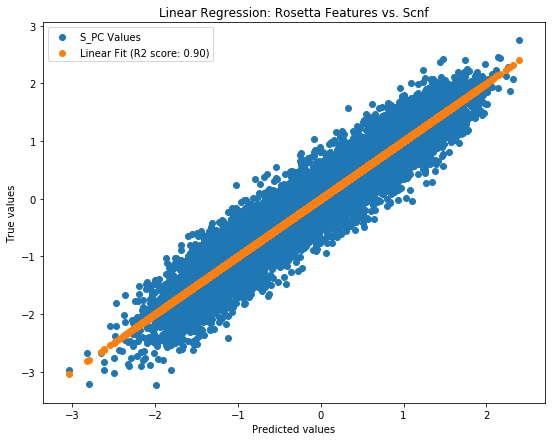

In [475]:
df = pd.DataFrame()
for i in range(1,11):
    df = df.append(diagnose_features(top10,model=LinearRegression(),X_train=X_train_scaled,X_test=X_test_scaled,y_train=y_train_scaled,y_test=y_test_scaled,score_cutoff=.5,combine=True,combine_number=i,plot=False))

dffig = plt.figure(figsize=(9,7))
#plt.subplot(211)
plt.scatter(predicted,y_test_scaled,label="S_PC Values")
plt.scatter(predicted,predicted,label='Linear Fit (R2 score: %0.2f)'%score)
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.title("Linear Regression: Rosetta Features vs. Scnf")
plt.legend()


# plt.subplot(212)

# table = top10
# cell_text = []
# for row in range(len(table)):
#     cell_text.append(table.iloc[row])

# plt.table(cellText=cell_text, colLabels=table.columns, loc='center')
# plt.axis('off')

# plt.subplots_adjust()

plt.show()
fig.savefig("./figures/linear_regression.svg",bbox_inches='tight')

In [598]:
df = pd.DataFrame()
for i in range(1,11):
    df = df.append(diagnose_features(top10,model=LinearRegression(),X_train=X_train_scaled,X_test=X_test_scaled,y_train=y_train_scaled,y_test=y_test_scaled,score_cutoff=.5,combine=True,combine_number=i,plot=False))

df.to_csv('./dataframes/LinearRegression_R2_outputs.csv')


		USING n_hydrophobic AS FEATURE



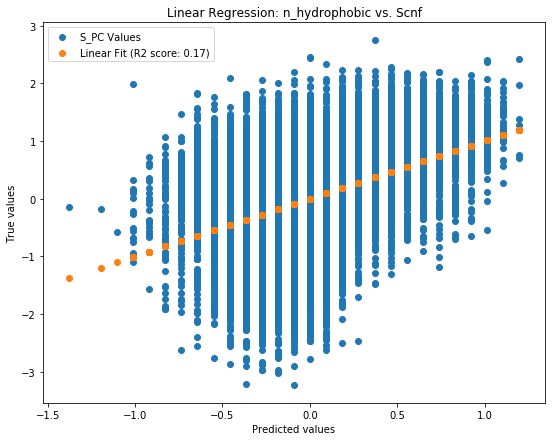


		USING Tend_absq AS FEATURE



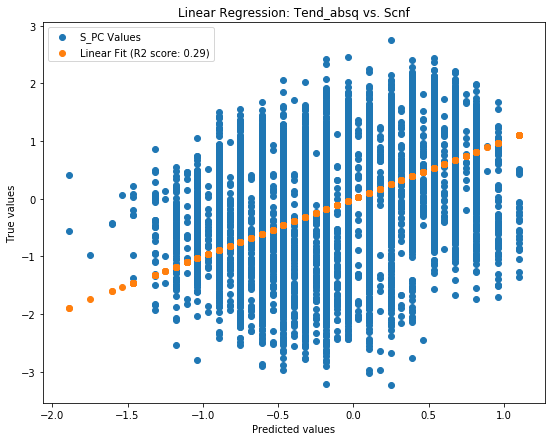


		USING Tend_netq AS FEATURE


		USING T1_netq AS FEATURE


		USING contact_all AS FEATURE


		USING nres AS FEATURE



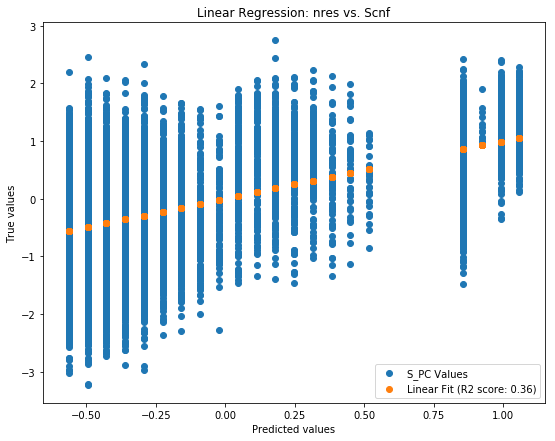


		USING entropy AS FEATURE


		USING dslf_fa13 AS FEATURE


		USING n_res AS FEATURE



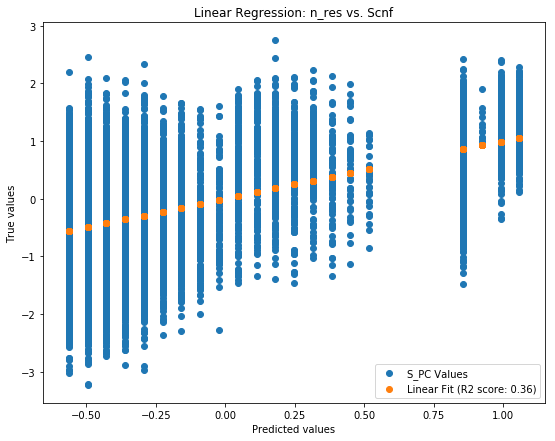


		USING buried_np AS FEATURE



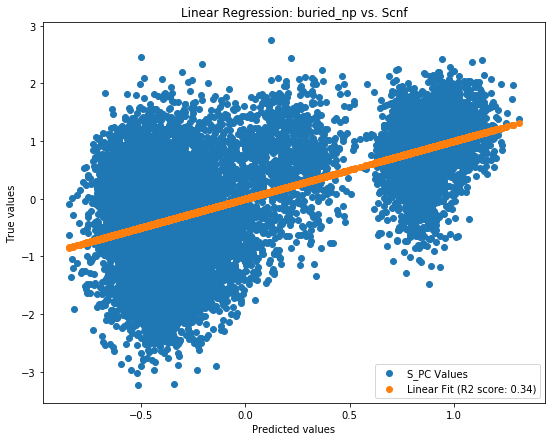

In [484]:
#build model with *just* the top 10 features for linear regression
features_to_use = list(top10['feature name'].values)
score_cutoff = .1
for feature in features_to_use:
    print("\n\t\tUSING %s AS FEATURE\n"%feature)
    #fit model
    lnr = LinearRegression(normalize=False)
    lnr.fit(X_train_scaled[feature].values.reshape(-1,1),y_train_scaled)
    predicted = lnr.predict(X_test_scaled[feature].values.reshape(-1,1))
    score = lnr.score(X_test_scaled[feature].values.reshape(-1,1),y_test_scaled)
    
    #plot it if the score is greater than cutoff
    if score>=score_cutoff:
        fig = plt.figure(figsize=(9,7))
        plt.scatter(predicted,y_test_scaled,label="S_PC Values")
        plt.scatter(predicted,predicted,label='Linear Fit (R2 score: %0.2f)'%score)
        plt.xlabel("Predicted values")
        plt.ylabel("True values")
        plt.title("Linear Regression: %s vs. Scnf"%feature)
        plt.legend()
        plt.show()

### LassoCV

In [653]:
#lasso cv looking for implicit expression of S_PC in rosetta
model_lassocv = LassoCV(cv=10)
model_lassocv.fit(X_train_scaled,y_train_scaled)
predicted_lassocv = model_lassocv.predict(X_test_scaled)
score_lassocv = model_lassocv.score(X_test_scaled,y_test_scaled)

#scatter_plot(predicted, y_test_scaled, score=score, title="LassoCV: Rosetta vs. Scnf",savefig=True,filename="lassocv_regression")

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [597]:
df.to_csv('./dataframes/LassoCV_R2_results.csv') #save output

In [552]:
lasso_top10 = get_top10(model_lassocv,X_train_scaled.columns)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

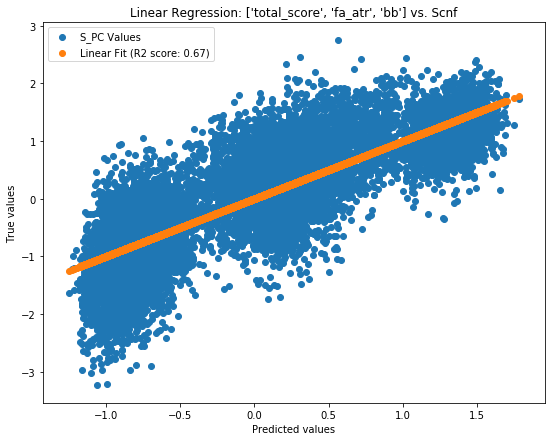

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

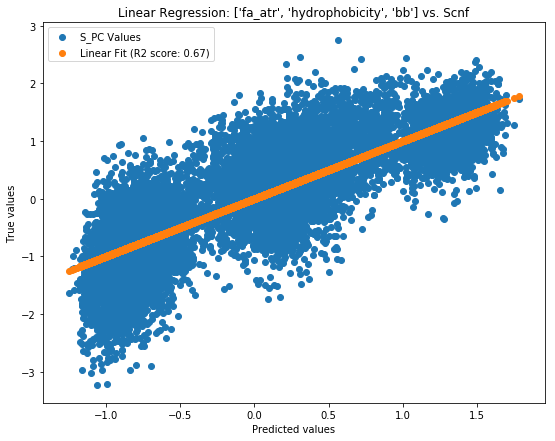

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

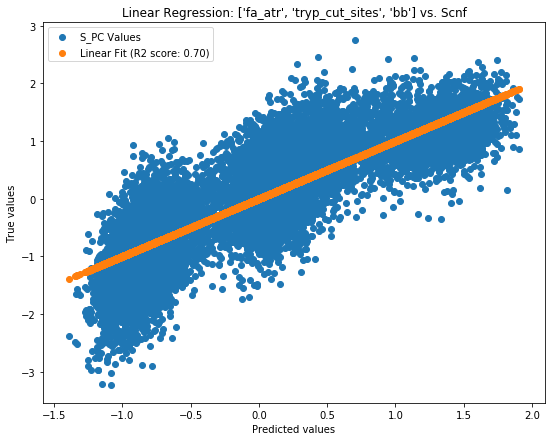

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

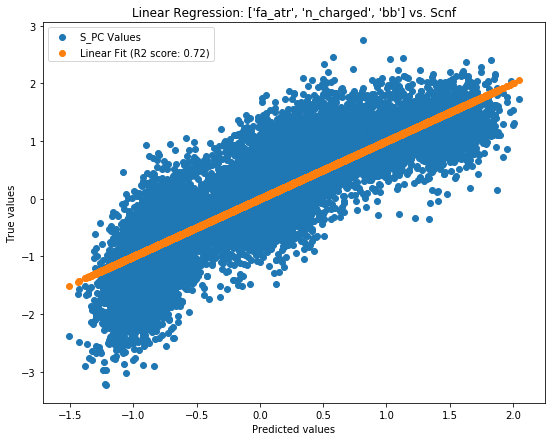

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


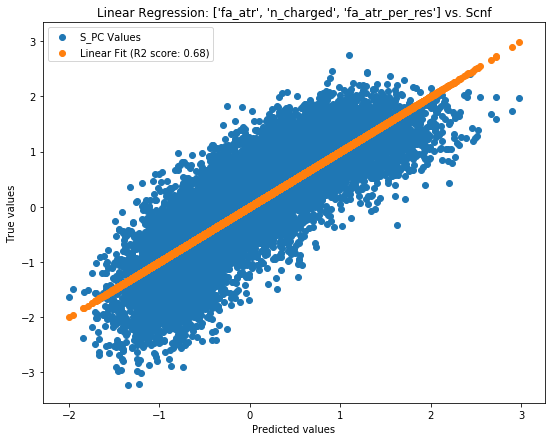

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


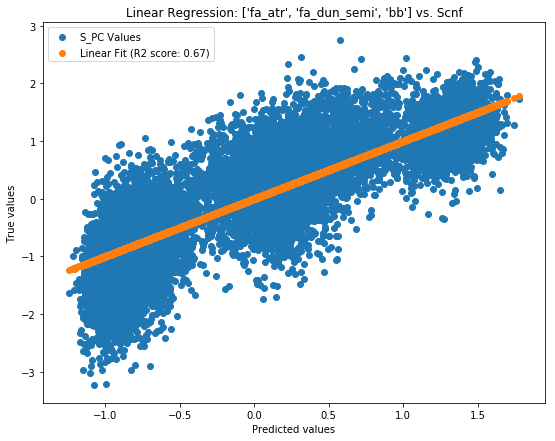

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


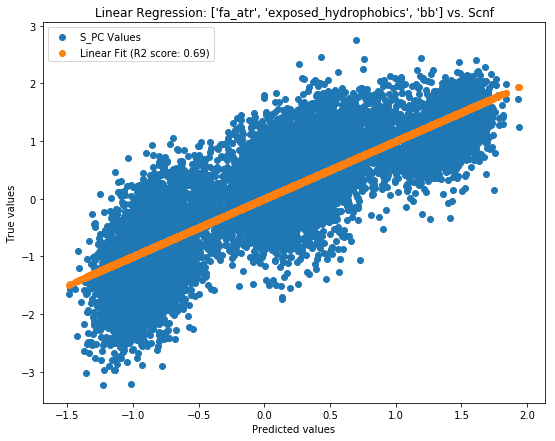

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


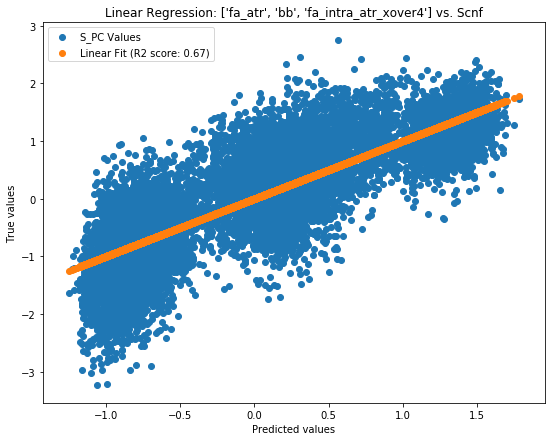

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


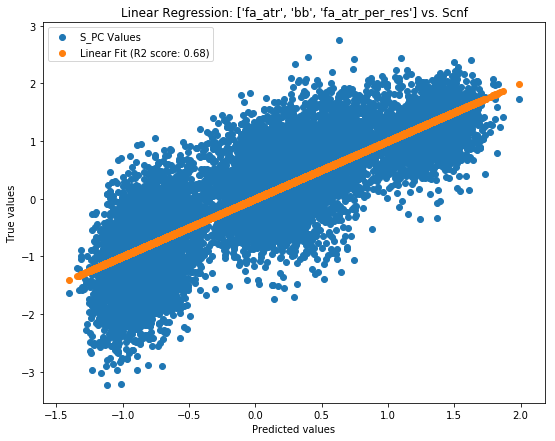

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

In [565]:
diagnose_features(lasso_top10,model=LassoCV(cv=3),X_train=X_train_scaled,X_test=X_test_scaled,y_train=y_train_scaled,y_test=y_test_scaled,score_cutoff=.67,combine=True,combine_number=3)

In [592]:
df = pd.DataFrame()
for i in range(1,11):
    df = df.append(diagnose_features(lasso_top10,model=LassoCV(cv=3),X_train=X_train_scaled,X_test=X_test_scaled,y_train=y_train_scaled,y_test=y_test_scaled,score_cutoff=.5,combine=True,combine_number=i,plot=False))

df

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,R2 score value,score name,n combinations
0,0.286058,[total_score],1
1,0.525133,[fa_atr],1
2,-7.09221e-07,[hydrophobicity],1
3,0.227735,[tryp_cut_sites],1
4,0.25081,[n_charged],1
5,0.0694928,[fa_dun_semi],1
6,0.357698,[exposed_hydrophobics],1
7,0.435074,[bb],1
8,0.349012,[fa_intra_atr_xover4],1
9,0.498282,[fa_atr_per_res],1


### RandomForestRegressor


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


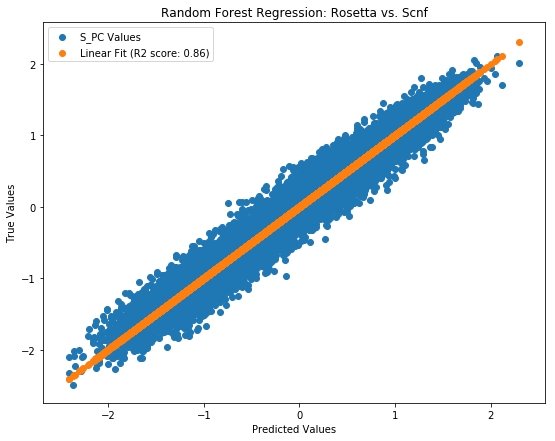

In [602]:
model_rfr = RandomForestRegressor()
model_rfr.fit(X_train_scaled,y_train_scaled)
predicted = model_rfr.predict(X_test_scaled)
score = r2_score(y_test_scaled,y_pred_scaled)

feature_importances = (list(zip(X_train.columns,model_rfr.feature_importances_))) #zips name of feature with importance
feature_importances.sort(key=lambda x: x[1],reverse=True) #sorts by second element in tuple

scatter_plot(predicted, y_pred_scaled,title="Random Forest Regression: Rosetta vs. Scnf",score=score, savefig=True,filename="RandomForestRegression")

rfr_top10 = pd.DataFrame(feature_importances[:10],columns=['feature name','Importance value'])


In [603]:
df = pd.DataFrame()
for i in range(1,11):
    df = df.append(diagnose_features(rfr_top10,model=RandomForestRegressor(),X_train=X_train_scaled,X_test=X_test_scaled,y_train=y_train_scaled,y_test=y_test_scaled,score_cutoff=.5,combine=True,combine_number=i,plot=False))

df.to_csv('./dataframes/RandomForestRegressor_R2_results.csv')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: DataConversionWarning: A column-vector y was passed whe

In [616]:
model = RFE(LassoCV(tol=.01),n_features_to_select=10) #changed tol form .0001 to .01 in order allow data to converge (https://stackoverflow.com/questions/20681864/lasso-on-sklearn-does-not-converge)
model.fit(X_train_scaled,y_train_scaled.ravel())
predited = model.predict(X_test_scaled)
score = model.score(X_test_scaled,y_test_scaled.ravel())
print("R2 score:",score)
print(model.transform(X_test_scaled))


R2 score: 0.8405091956760175
[[ 0.77982383 -0.66214436 -0.71145155 ... -0.49035994 -0.27661923
  -0.08856842]
 [-0.35211864  0.85087122  1.74841326 ... -0.04546687 -0.87985569
  -0.87255911]
 [-0.35211864 -0.61389843 -1.13643963 ... -0.20117945  0.58514715
   0.69542227]
 ...
 [-0.35211864  1.30312229  0.24547526 ... -1.8472838  -0.10426595
  -0.34989865]
 [-2.05003234  1.78409742  1.03916162 ... -0.86534124 -1.31073888
  -1.13388934]
 [ 0.77982383  0.87348377 -1.36441337 ... -0.90029713 -0.96603233
  -0.61122888]]


In [619]:
rfe_results = pd.DataFrame(list(zip(list(X_train_scaled.columns),list(model.support_))))
rfe_results[rfe_results.iloc[:,1]==1]
#model.ranking_

,0,1
0,AlaCount,True
37,fa_atr,True
38,fa_atr_per_res,True
41,fa_dun_semi,True
46,fa_intra_sol_xover4,True
49,fa_sol,True
58,hbond_sr_bb,True
65,hydrophobicity,True
73,n_charged,True
109,tryp_cut_sites,True


### Relationship between `fa_atr`,`n_charged`, `fa_atr_per_res`  vs `S_PC`

Merge worked: True


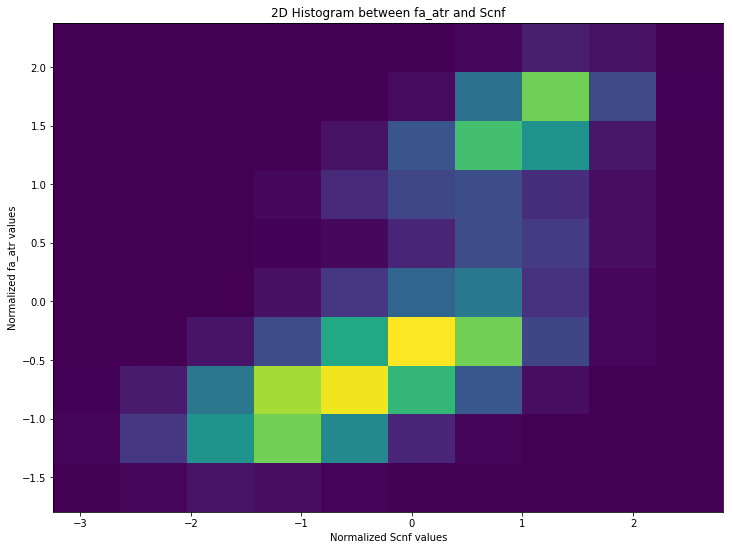

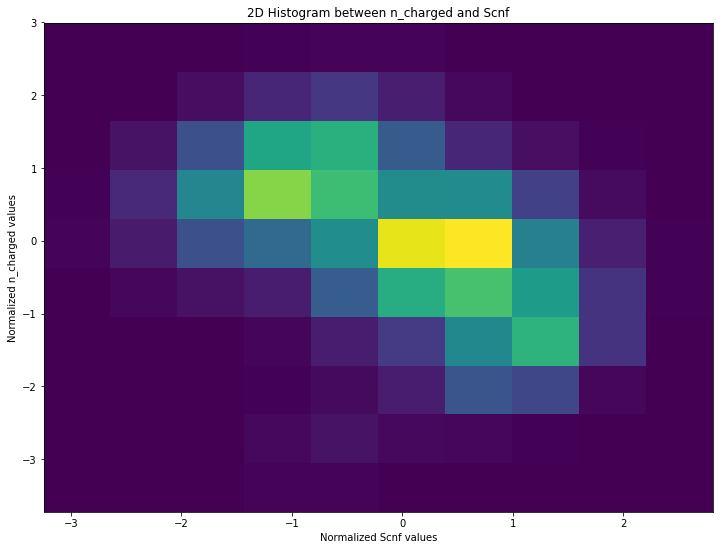

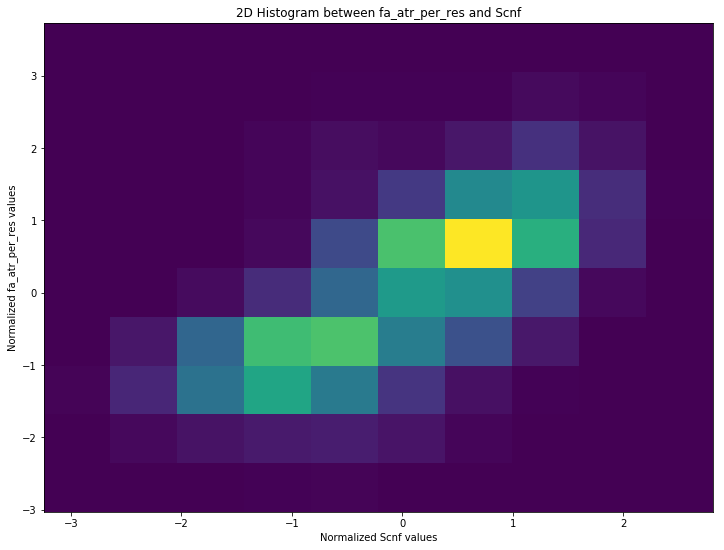

In [726]:
#make a big df with test and train

one_d_yvalues = pd.DataFrame(list(map(lambda x:x[0],y_scaled)),columns=['S_PC'])

df = pd.concat([X_scaled,one_d_yvalues],axis=1)

print("Merge worked:",(len(df)==(len(df_aggregated_train)+len(df_aggregated_test))))

features_to_vis = ['fa_atr','n_charged','fa_atr_per_res']

for feature in features_to_vis:
    fig = plt.figure(figsize=(12,9))
    plt.hist2d(x=df['S_PC'],y=df[feature],)
    plt.xlabel('Normalized Scnf values')
    plt.ylabel('Normalized %s values'%feature)
    plt.title('2D Histogram between %s and Scnf'%feature)
    plt.show()

    fig.savefig('/home/jupyter/tacc-work/model_building/figures/2dHistogram_%s.svg'%feature,bbox_inches='tight')


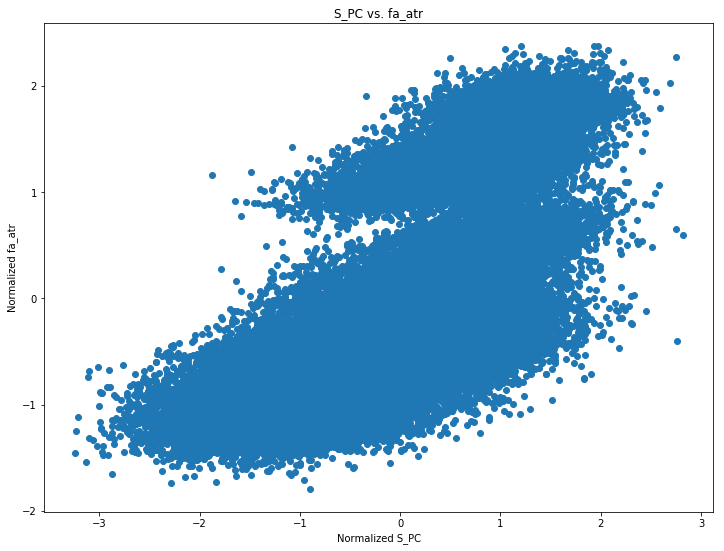

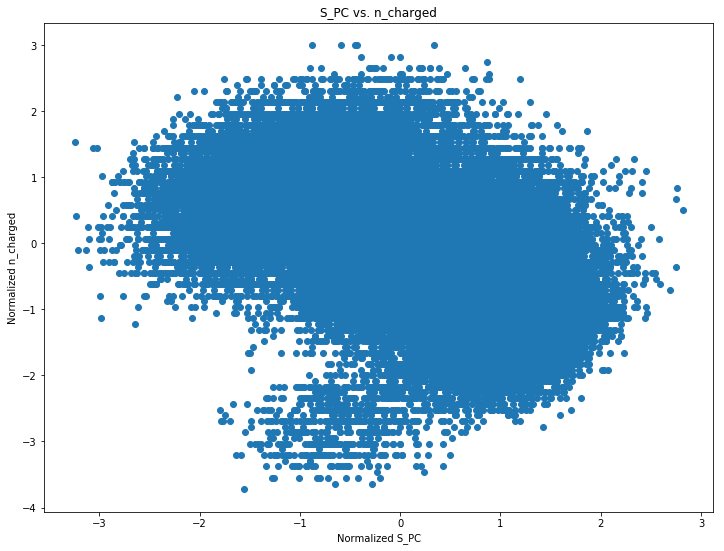

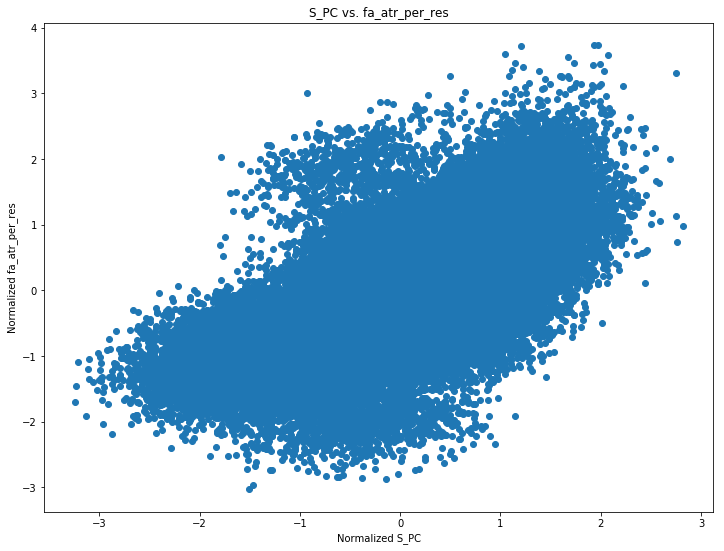

In [727]:
for feature in features_to_vis:
    fig = plt.figure(figsize=(12,9))
    plt.scatter(x=df['S_PC'],y=df[feature])
    plt.title("S_PC vs. %s"%feature)
    plt.xlabel("Normalized S_PC")
    plt.ylabel("Normalized %s"%feature)
    plt.show()
    
    fig.savefig("/home/jupyter/tacc-work/model_building/figures/scatter_%s.svg"%feature,bbox_inches='tight')

In [708]:
def make_binary_col(data,feature,cutoff=None):
    if cutoff==None:
        cutoff = get_cutoff(data,feature)
    data['binary_'+feature]=data[feature]>cutoff
    return data,cutoff
    

In [704]:
def get_cutoff(data,feature):
    max_val = data[feature].max()
    min_val = data[feature].min()
    mid_val = (max_val+min_val)/2
    return mid_val

In [715]:
#in order to get tptn values for these features, they have to be converted to binary data
X_test_scaled['predicted_lassocv'] = predicted_lassocv


In [721]:
tp,tn,fp,fn = tptn(pred['binary_S_PC'],true['binary_S_PC'])

Number of TP: 6790
Number of TN: 4441
Number of FP: 452
Number of FN: 467



In [ ]:
fig = plt.figure(figsize=(12,9))
plt.scatter()

## Binarize Results

In [47]:
boop = []
for i in list(predicted_lnr):
    boop.append(i[0])
    
boop

[-1.279939620611289,
 1.189823632910146,
 -0.906749819650475,
 0.09031147827527236,
 -0.32664121724938155,
 0.3596416722741075,
 0.3593641709923086,
 -0.6603508822906916,
 0.10862934403332695,
 1.8109250610192285,
 -0.04618906814328314,
 -1.3411291543837296,
 -0.19684296710570517,
 0.6013834715300903,
 -0.417207339177385,
 -1.0194020934198098,
 -1.379775728251068,
 -0.22210030949592238,
 0.09603840573198126,
 0.1510353163328831,
 -0.9486405083130622,
 0.10665450380277973,
 -0.7862346740229724,
 -0.41316516669399633,
 0.589871329564335,
 0.8662775067847319,
 -0.28232087130835426,
 0.3536342608829886,
 -0.8046198031517887,
 -0.28323452589703774,
 0.47864822028186993,
 -1.2988290071103432,
 1.1919201303557805,
 -0.8247133687822044,
 -1.191016855861045,
 -1.4498928854819182,
 -0.437110496210817,
 0.5942981507367121,
 -0.015005806564673539,
 0.7030084307373038,
 0.6253179509508785,
 -0.48457668501893225,
 0.09741888788494547,
 -0.7817650010478733,
 -0.35559148024909104,
 -1.2140809043720457

In [62]:
#add predicted values to testing dataframe

#make a df for the predicted values
predicted_rfr = list(model_rfr.predict(X_test_scaled))
predicted_lassoCV = list(model_lassocv.predict(X_test_scaled))
predicted_lnr = list(model_lnr.predict(X_test_scaled))

#fix predicted_lnr
new_list = []
for i in predicted_lnr:
    new_list.append(i[0])
predicted_lnr = new_list

predictions = pd.DataFrame(data={"predicted RFR":predicted_rfr,
                                 "predicted LassoCV":predicted_lassoCV,
                                 "predicted LNR":predicted_lnr})

In [63]:
testing_dataframe = pd.concat([df_aggregated_test,predictions],axis=1)


In [64]:
#if the predicted value is within .1 of the true value, then it will be counted as "True"
abs(testing_dataframe['S_PC'] - testing_dataframe['predicted RFR']) <= .01

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
12120    False
12121    False
12122    False
12123    False
12124    False
12125    False
12126    False
12127    False
12128    False
12129    False
12130    False
12131    False
12132    False
12133    False
12134    False
12135    False
12136    False
12137    False
12138    False
12139    False
12140    False
12141    False
12142     True
12143    False
12144    False
12145    False
12146    False
12147    False
12148    False
12149    False
Length: 12150, dtype: bool

In [157]:
def correct_predictions(list_of_col,df,target,cutoff=7):
    list_of_results = []
    for col in list_of_col:
        difference = abs(df[target]-df[col])
        list_of_results.append(difference <= cutoff)
    return list_of_results

In [158]:
bin_rfr,bin_lassoCV,bin_lnr = correct_predictions(['predicted RFR','predicted LassoCV','predicted LNR'],testing_dataframe,'S_PC')

In [159]:
#dataframe of predicted values as binary
correct_pred = pd.DataFrame({"correct RFR":bin_rfr,'correct lassoCV':bin_lassoCV,"correct LNR":bin_lnr})

In [160]:
false_true = np.unique(correct_pred['correct RFR'],return_counts=True)[1]
total = false_true[0]+false_true[1]
percent_accuracy = (false_true[1]/total)*100
print(false_true,percent_accuracy)

[4214 7936] 65.31687242798354


In [ ]:
"""
TODO: Figure out how to solve this.
Max value of S_PC is: 21.81   \   
                               ----------------- These have been normalized. 
Min value of S_PC is: -21.12  /

I have the predicted values for the LinearRegression,
LassoCV, and RandomForestRegressor

I converted the continuous values from the regressions to 
binary values by using a cutoff. If the absolute value
difference between the 'true' S_PC values and the 'predicted'
S_PC values were less than or equal to the cutoff, then its
binary value was "True". Else, the binary value is "False"


The Following Results are for RandomForestRegressor (R² = .86)
When the cutoff is .1:
    False count: 12035
    True count: 115
    % accuracy: 0.947

When the cutoff is 1:
    False count: 10976
    True count: 1174
    % accuracy: 9.66

When the cutoff is 3:
    False count: 8666
    True count: 3484
    % accuracy: 28.7
    
When the cutoff is 5:
    False count: 6348
    True count: 5802
    % accuracy: 47.8
    
When the cutoff is 7:
    False count: 4214
    True count: 7936
    % accuracy: 65.3
    
When the cutoff is 10:
    False count: 1612
    True count: 10537
    % accuracy: 86.7


I do not understand how the R² value can be so high yet the predictions have such a high margin of error. 
A positive side of this is that I can now make these values binary which can lead to TP/FP/TN/FN analysis
as with the classifiers. 
A negative side is that the regressor seems to have a large error. 

Should I:
    - focus on fine tuning the regressors 
    - search for an overlap between mispredictions of these regressors and 
        the classifiers even if these are not highly accurate
    

"""

In [168]:
def get_data(cutoff=1,correct_predictions=correct_pred, list_of_col=['correct RFR','correct lassoCV','correct LNR']):
    data = []
    for i in list_of_col:
        false_true = np.unique(correct_predictions[i],return_counts=True)[1]
        total = false_true[0]+false_true[1]
        percent_accuracy = (false_true[1]/total)*100
        results = {'model':i,
                   'cutoff':cutoff,
                   'false count':false_true[0],
                   'true count':false_true[1],
                   '% accuracy':percent_accuracy}
        data.append(results)
    return data

In [177]:
pd.DataFrame(get_data()).columns

Index(['% accuracy', 'cutoff', 'false count', 'model', 'true count'], dtype='object')

In [198]:
cutoff_values = np.arange(.1,10.1,step=.1)

In [202]:
list_of_predictions = ['predicted RFR','predicted LassoCV','predicted LNR']
dataframe = testing_dataframe
target = 'S_PC'
total_results = pd.DataFrame(columns=['model','cutoff','true count','false count','% accuracy'])
for cutoff in cutoff_values:
    #convert values to binary using cutoff
    bin_rfr,bin_lassoCV,bin_lnr = correct_predictions(list_of_predictions,
                                                      dataframe,'S_PC',cutoff=cutoff)
    #make a dataframe from binary results
    dataframe_binary = pd.DataFrame({"correct RFR":bin_rfr,'correct lassoCV':bin_lassoCV,"correct LNR":bin_lnr})
    
    #get results from the dataframe
    results = pd.DataFrame(get_data(cutoff=cutoff, correct_predictions=dataframe_binary))
        
    #append the results to the larger dataframe
    total_results = total_results.append(results,ignore_index=True)

total_results = total_results[['model','cutoff','true count','false count','% accuracy']]

In [205]:
total_results[total_results['% accuracy']>=80]

,model,cutoff,true count,false count,% accuracy
264,correct RFR,8.9,9731,2419,80.090535
265,correct lassoCV,8.9,9785,2365,80.534979
266,correct LNR,8.9,9799,2351,80.650206
267,correct RFR,9.0,9807,2343,80.716049
268,correct lassoCV,9.0,9858,2292,81.135802
269,correct LNR,9.0,9866,2284,81.201646
270,correct RFR,9.1,9886,2264,81.366255
271,correct lassoCV,9.1,9934,2216,81.761317
272,correct LNR,9.1,9947,2203,81.868313
273,correct RFR,9.2,9970,2180,82.057613
